## 2014-2019 Sample sale transactional data of 57 drugs classified as:
Anatomical Therapeutic Chemical (ATC) Classification System:
- M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
- M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
- N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
- N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides
- N05B - Psycholeptics drugs, Anxiolytic drugs
- N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
- R03 - Drugs for obstructive airway diseases
- R06 - Antihistamines for systemic use
- Sales data are resampled to the hourly, daily, weekly and monthly periods. 
- Data is already pre-processed, where processing included outlier detection and treatment and missing data imputation.

ATC codes features are added to the dataset, namely a model has been transformed as indicated on the image below and data was resampled to the hourly time-series.

Sales Transations: DateTime, Brand Name, Quantity
Hourly Sales data: Hour, Quantity: M01AB, M01AE,N02BA,N02BE/B, N05B,N05C,R03 & R06

In [126]:
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid


In [127]:
pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [128]:
# Import csv files
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
# Files to Load
daily = "Resources/salesdaily.csv"
hourly ="Resources/saleshourly.csv"
monthly ="Resources/salesmonthly.csv"
weekly ="Resources/salesweekly.csv"

In [129]:
dailydf = pd.read_csv(daily)
dailydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday_Name
0,1/2/2014,0.0,3.67,3.4,32.40,7.0,0.0,0.0,2.0,2014,1,248,Thursday
1,1/3/2014,8.0,4.00,4.4,50.60,16.0,0.0,20.0,4.0,2014,1,276,Friday
2,1/4/2014,2.0,1.00,6.5,61.85,10.0,0.0,9.0,1.0,2014,1,276,Saturday


In [130]:
hourlydf = pd.read_csv(hourly)
hourlydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.0,0.67,0.4,2.0,0.0,0.0,0.0,1.0,2014,1,8,Thursday
1,1/2/2014,0.0,0.00,1.0,0.0,2.0,0.0,0.0,0.0,2014,1,9,Thursday
2,1/2/2014,0.0,0.00,0.0,3.0,2.0,0.0,0.0,0.0,2014,1,10,Thursday


In [143]:
monthlydf = pd.read_csv(monthly)
monthlydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year
0,01-31-2014,127.69,99.09,152.100,878.030,354.0,50,112.0,48.2,2014
1,02-28-2014,133.32,126.05,177.000,1001.900,347.0,31,122.0,36.2,2014
2,03-31-2014,137.44,92.95,147.655,779.275,232.0,20,112.0,85.4,2014


In [132]:
weeklydf = pd.read_csv(weekly)
weeklydf.head(3)

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0


## Time series analysis

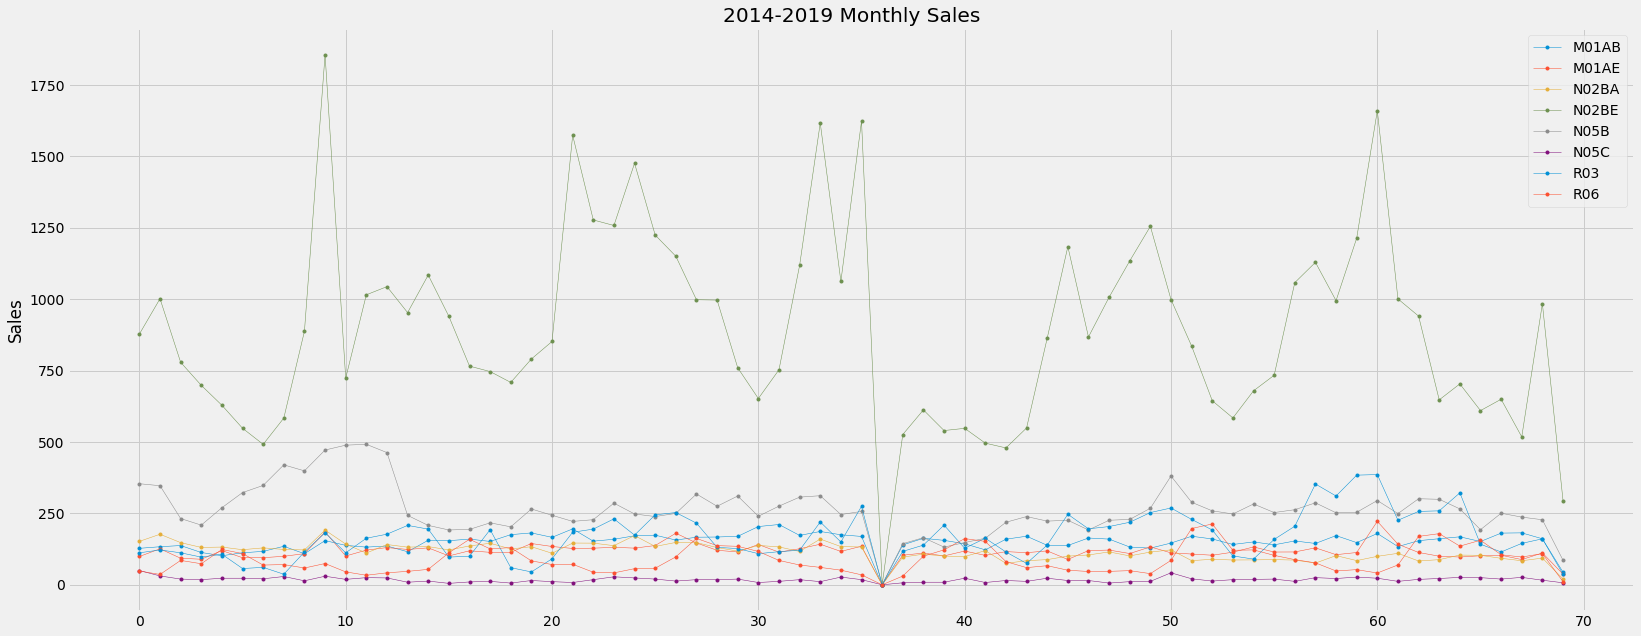

In [158]:
fig, ax = plt.subplots(figsize=(25, 10))
for nm in cols_plot:
    ax.plot(monthlydf[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Sales')
    ax.set_title('2014-2019 Monthly Sales');

In [150]:
def plot_yearly_sales(column):
    monthlydf.groupby('Year')[column].mean().plot.bar()#calculating yearly sales using groupby
    plt.title(f'Yearly sales of {column}')
    plt.xlabel('Year')
    plt.ylabel('Sales')
    plt.show()

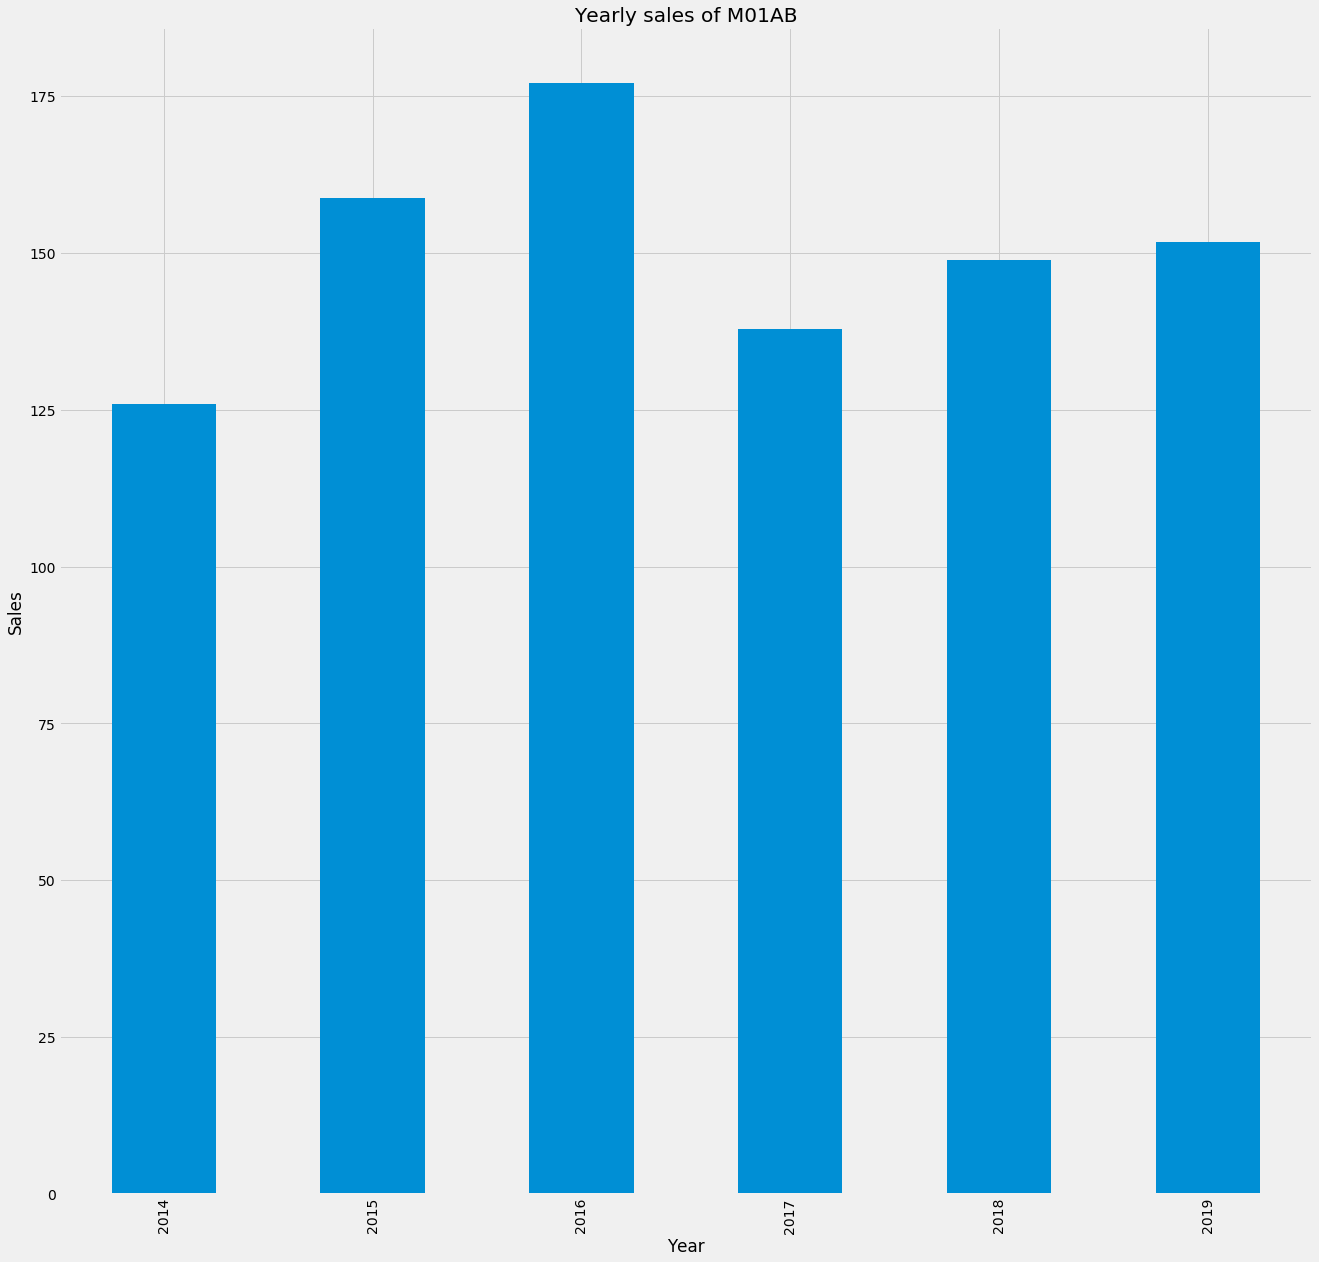

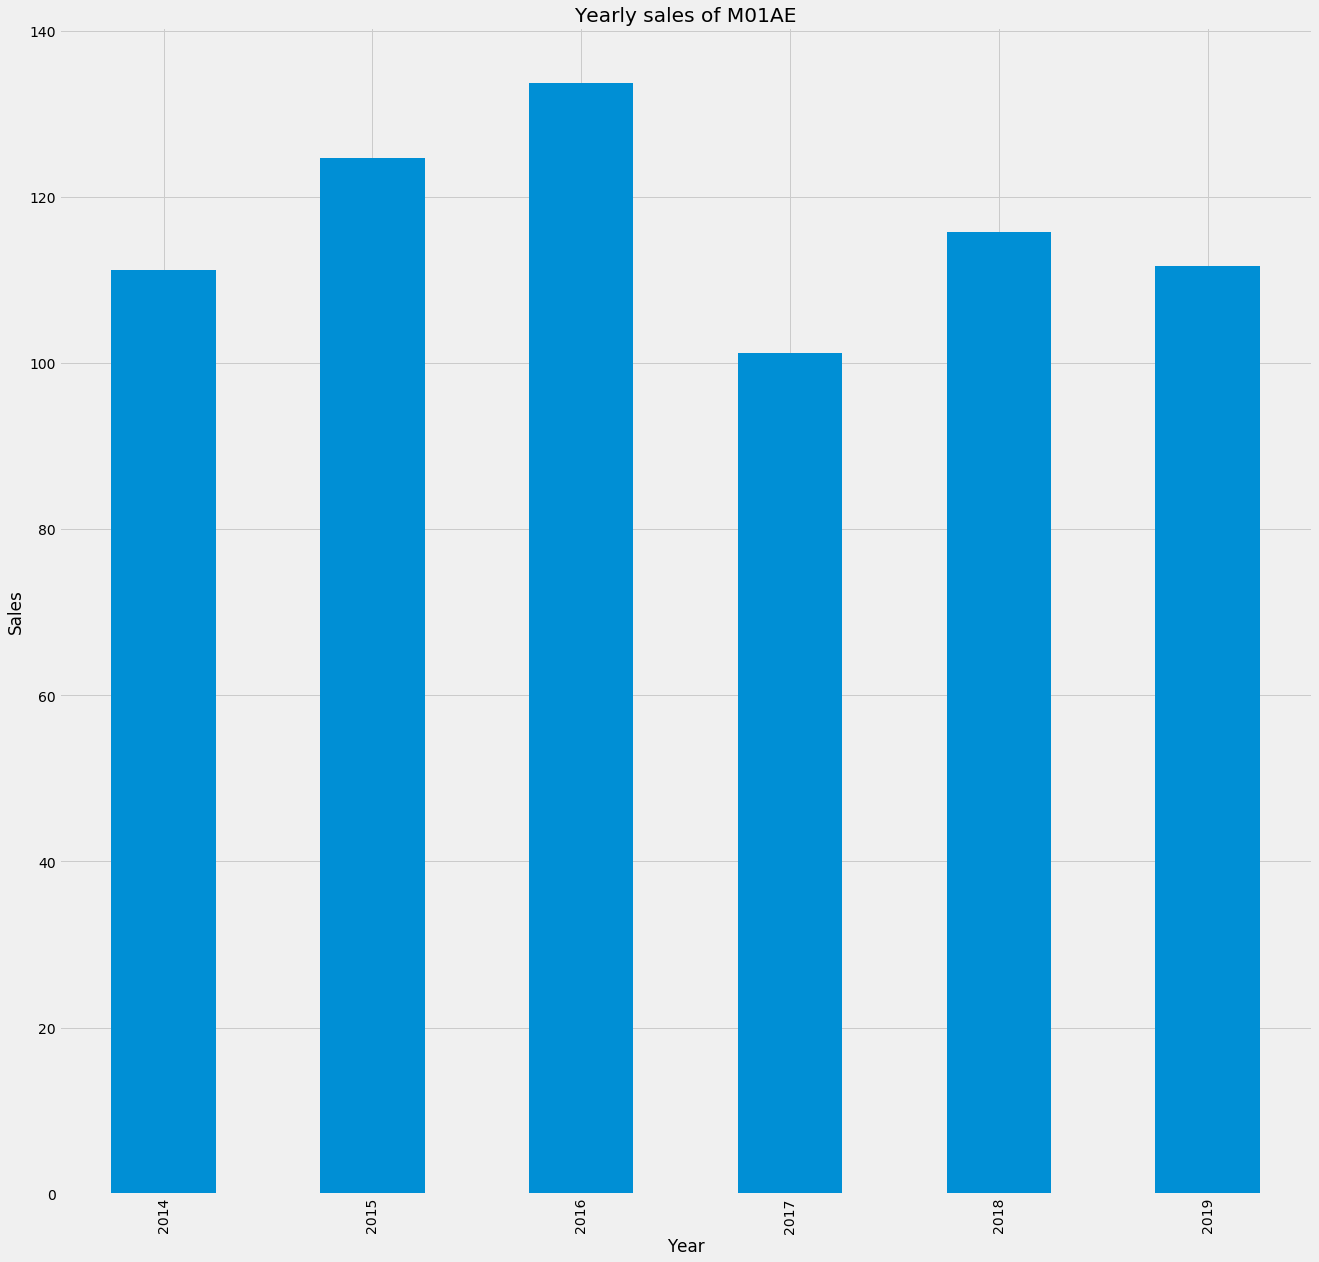

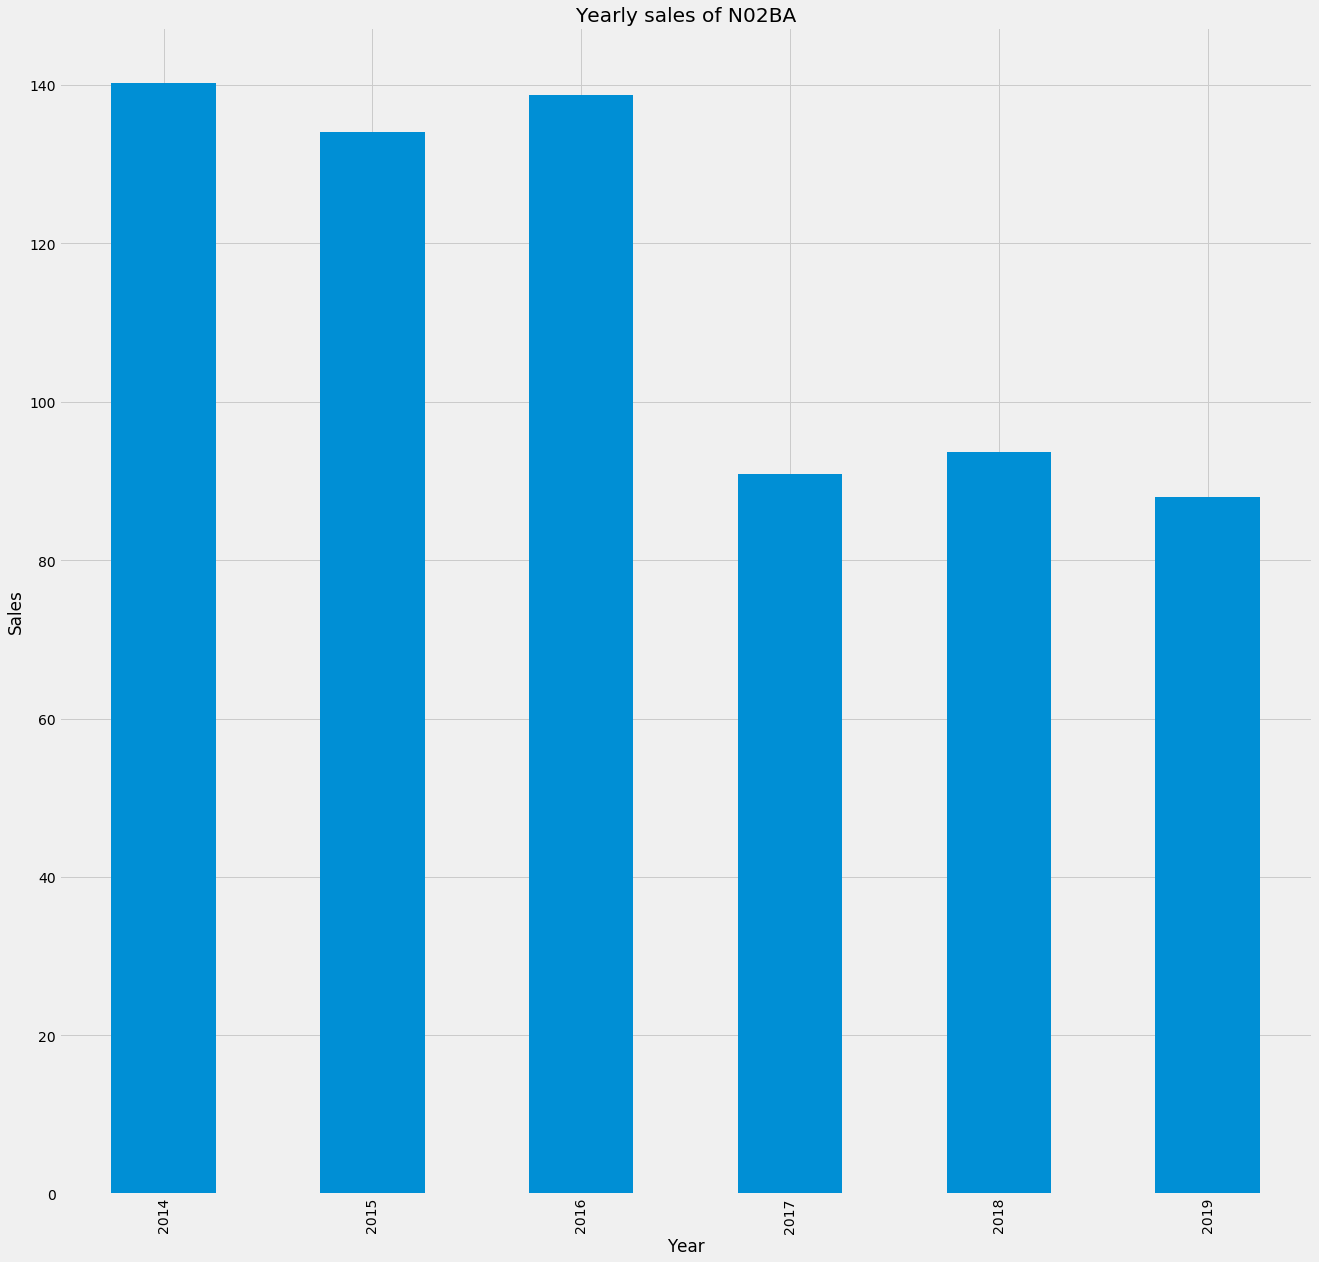

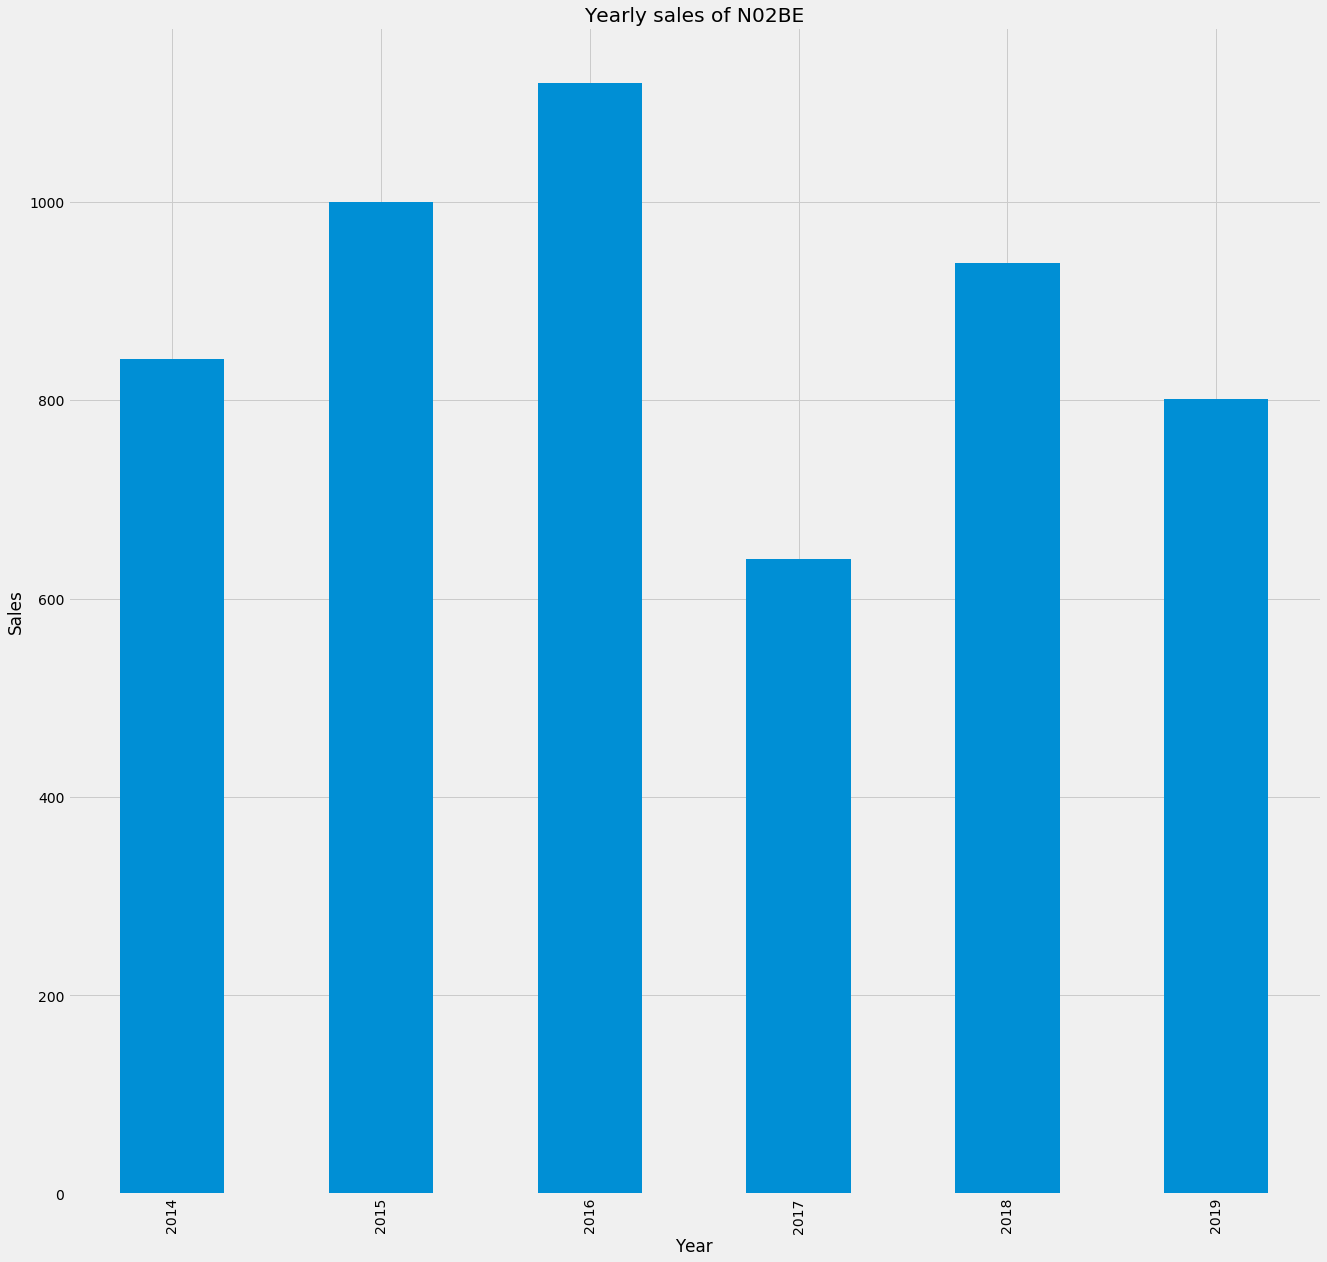

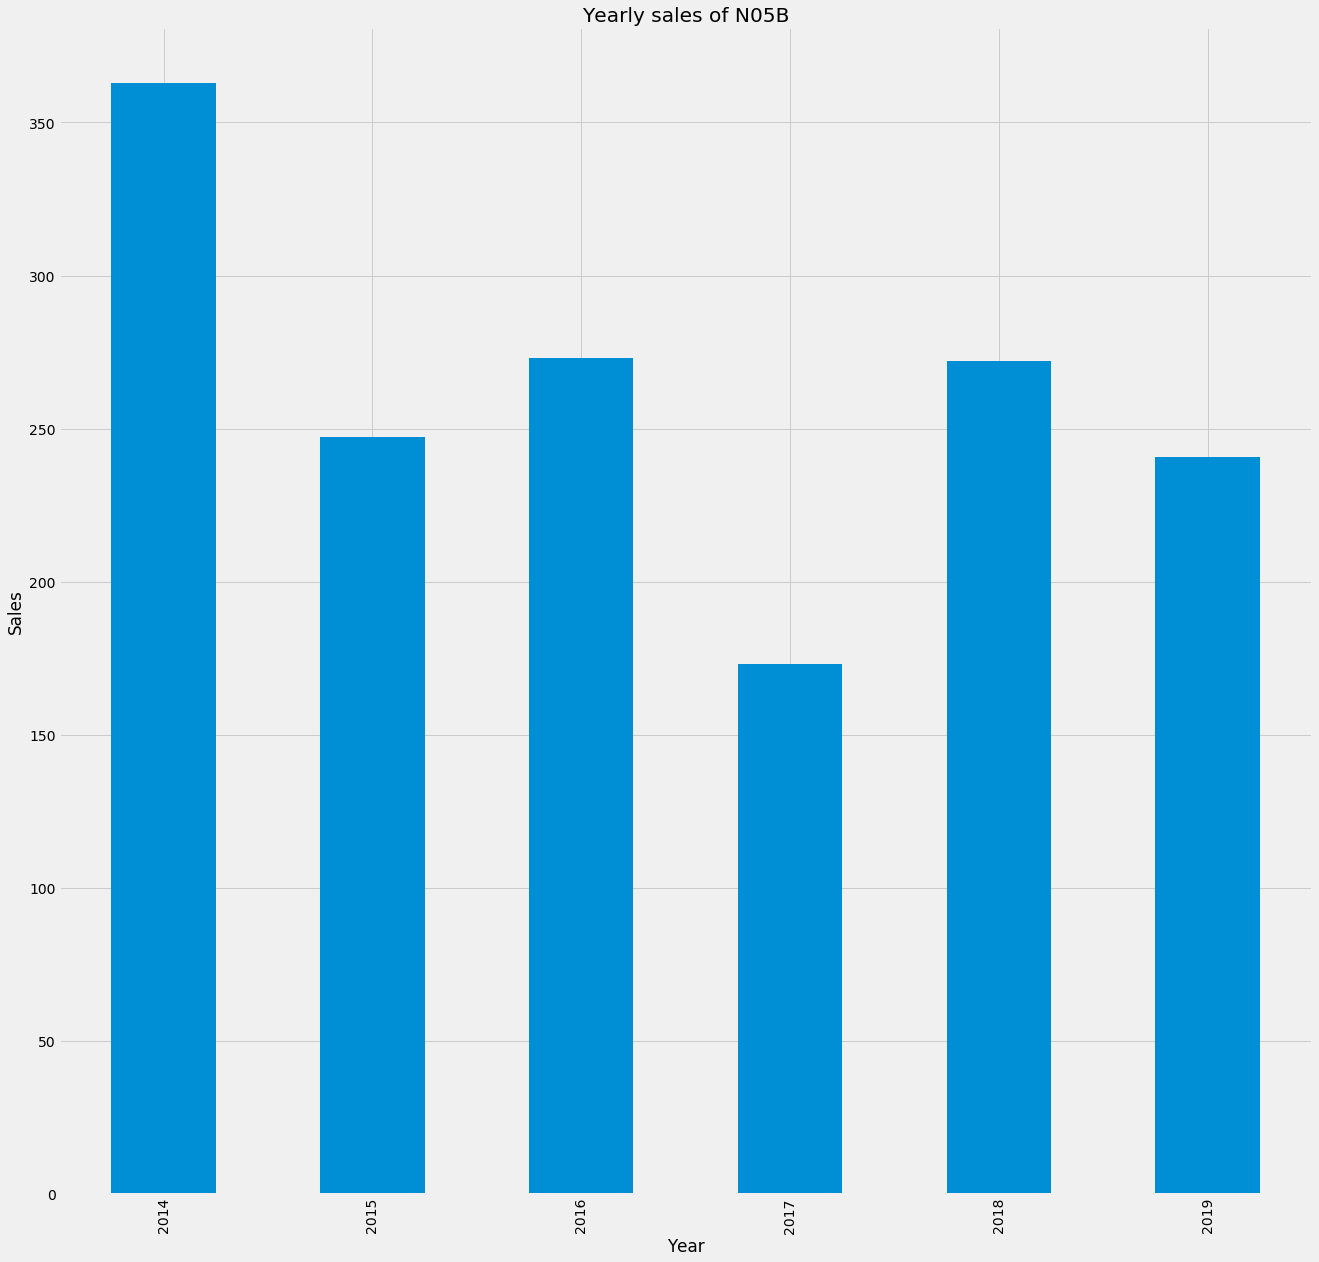

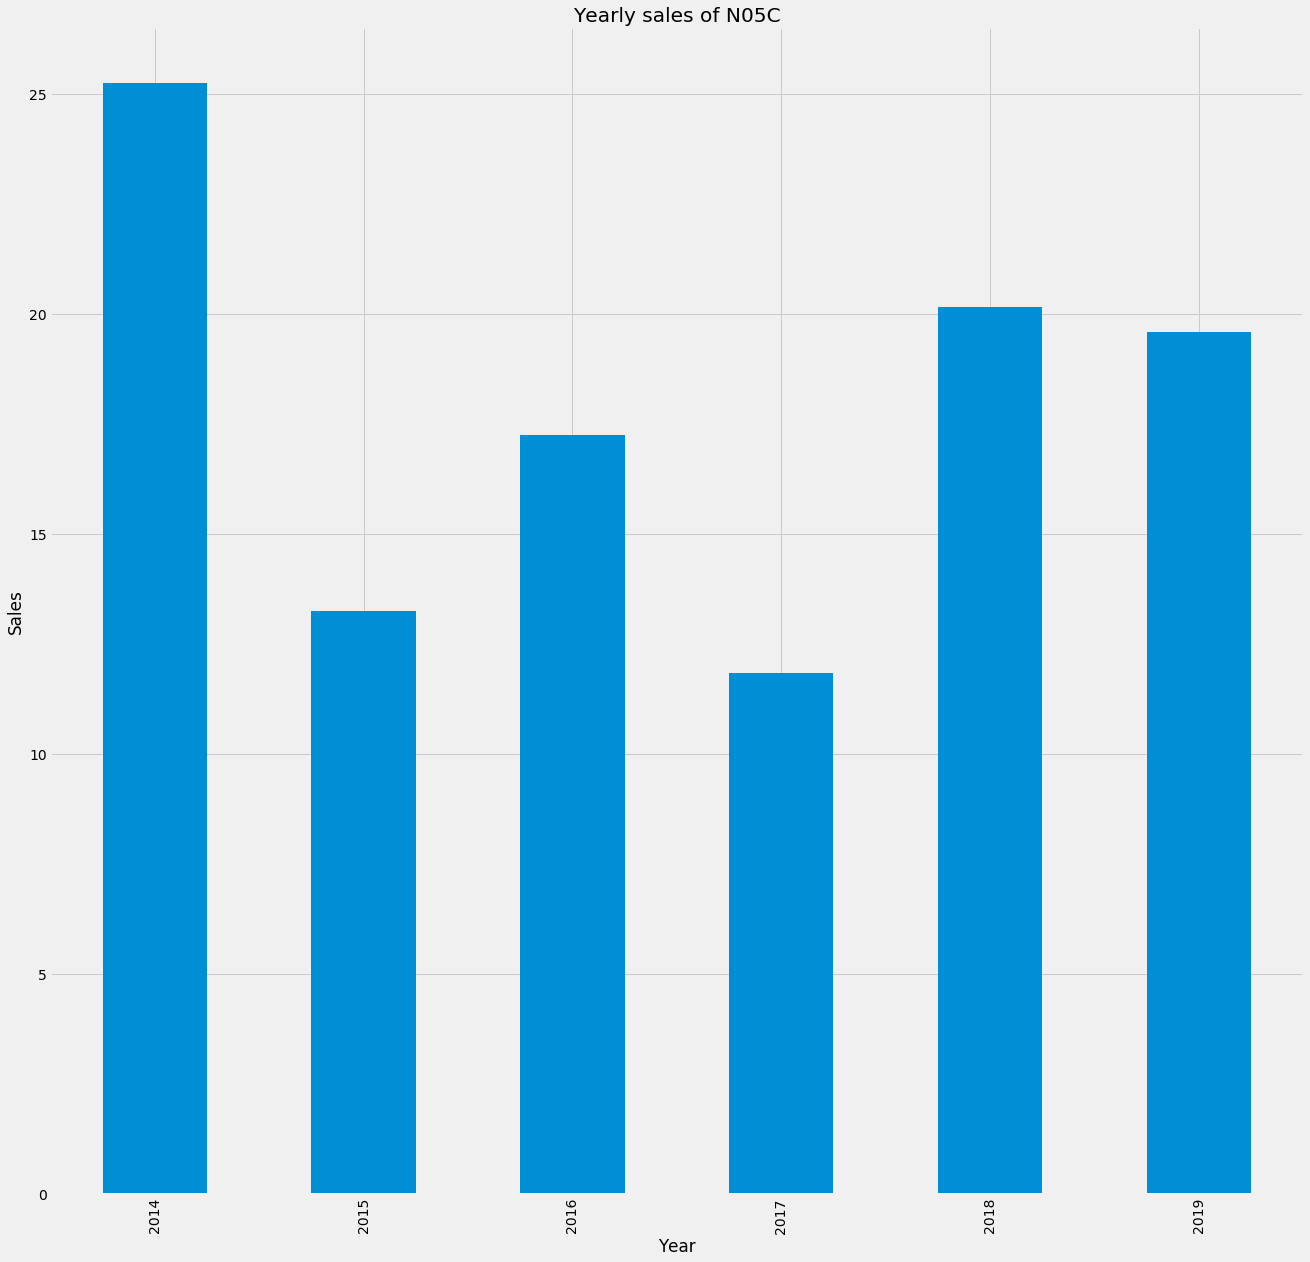

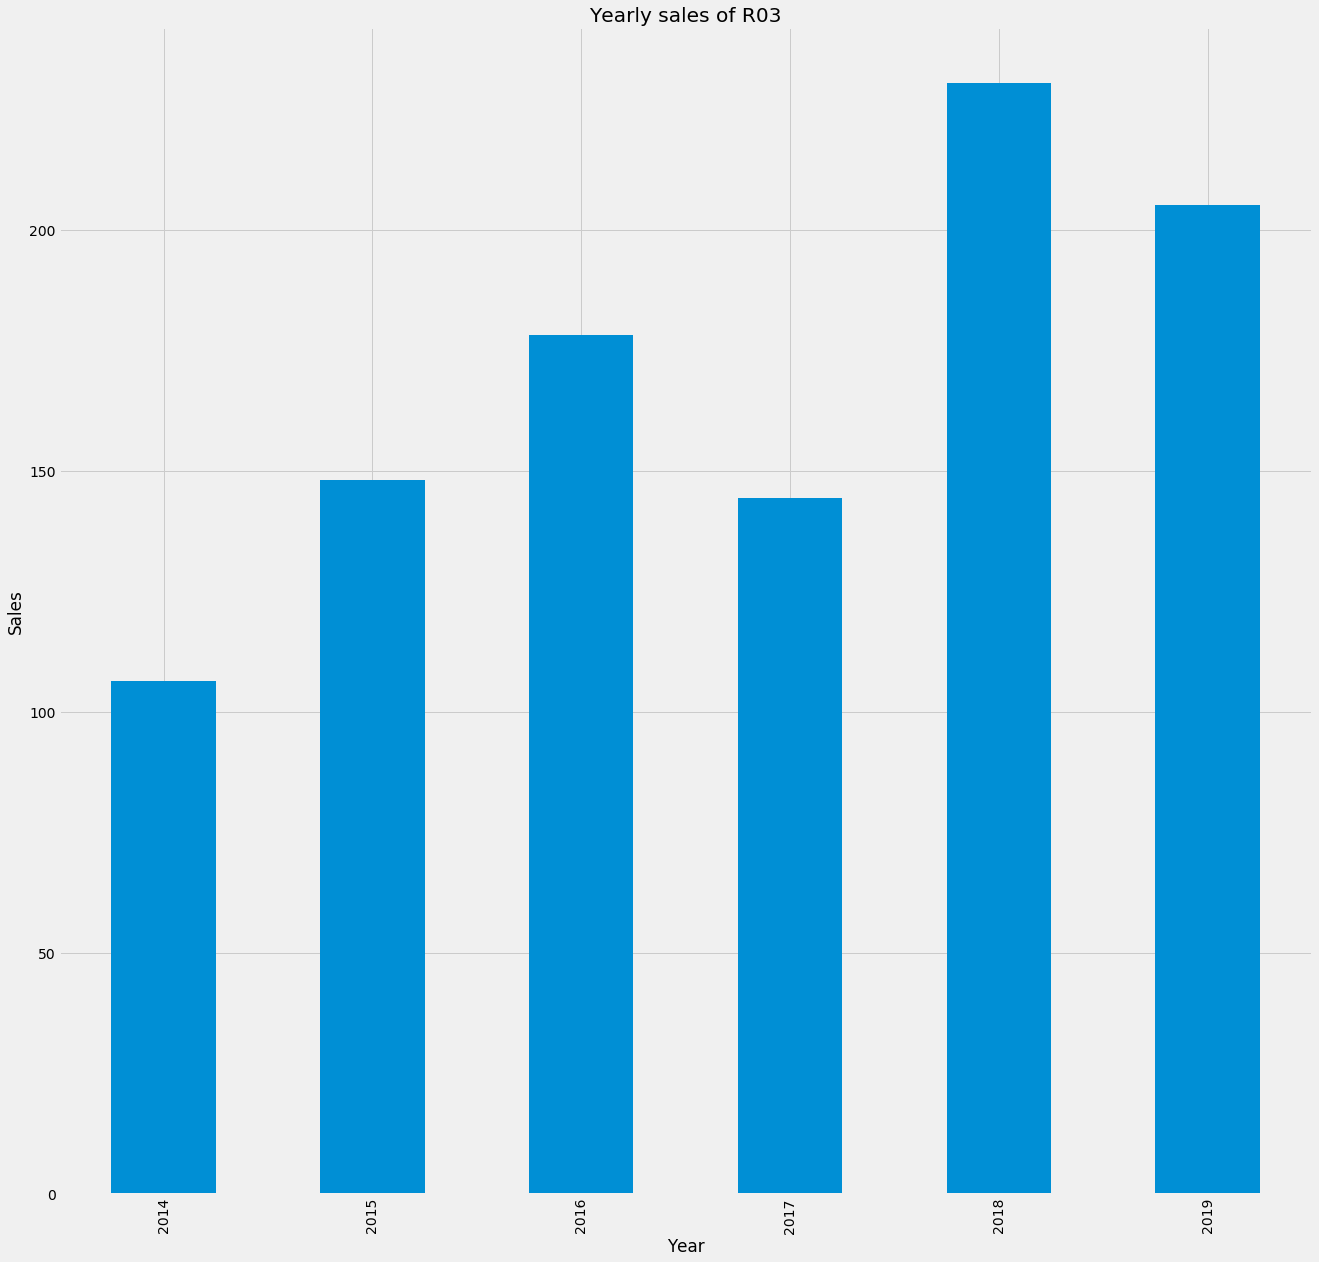

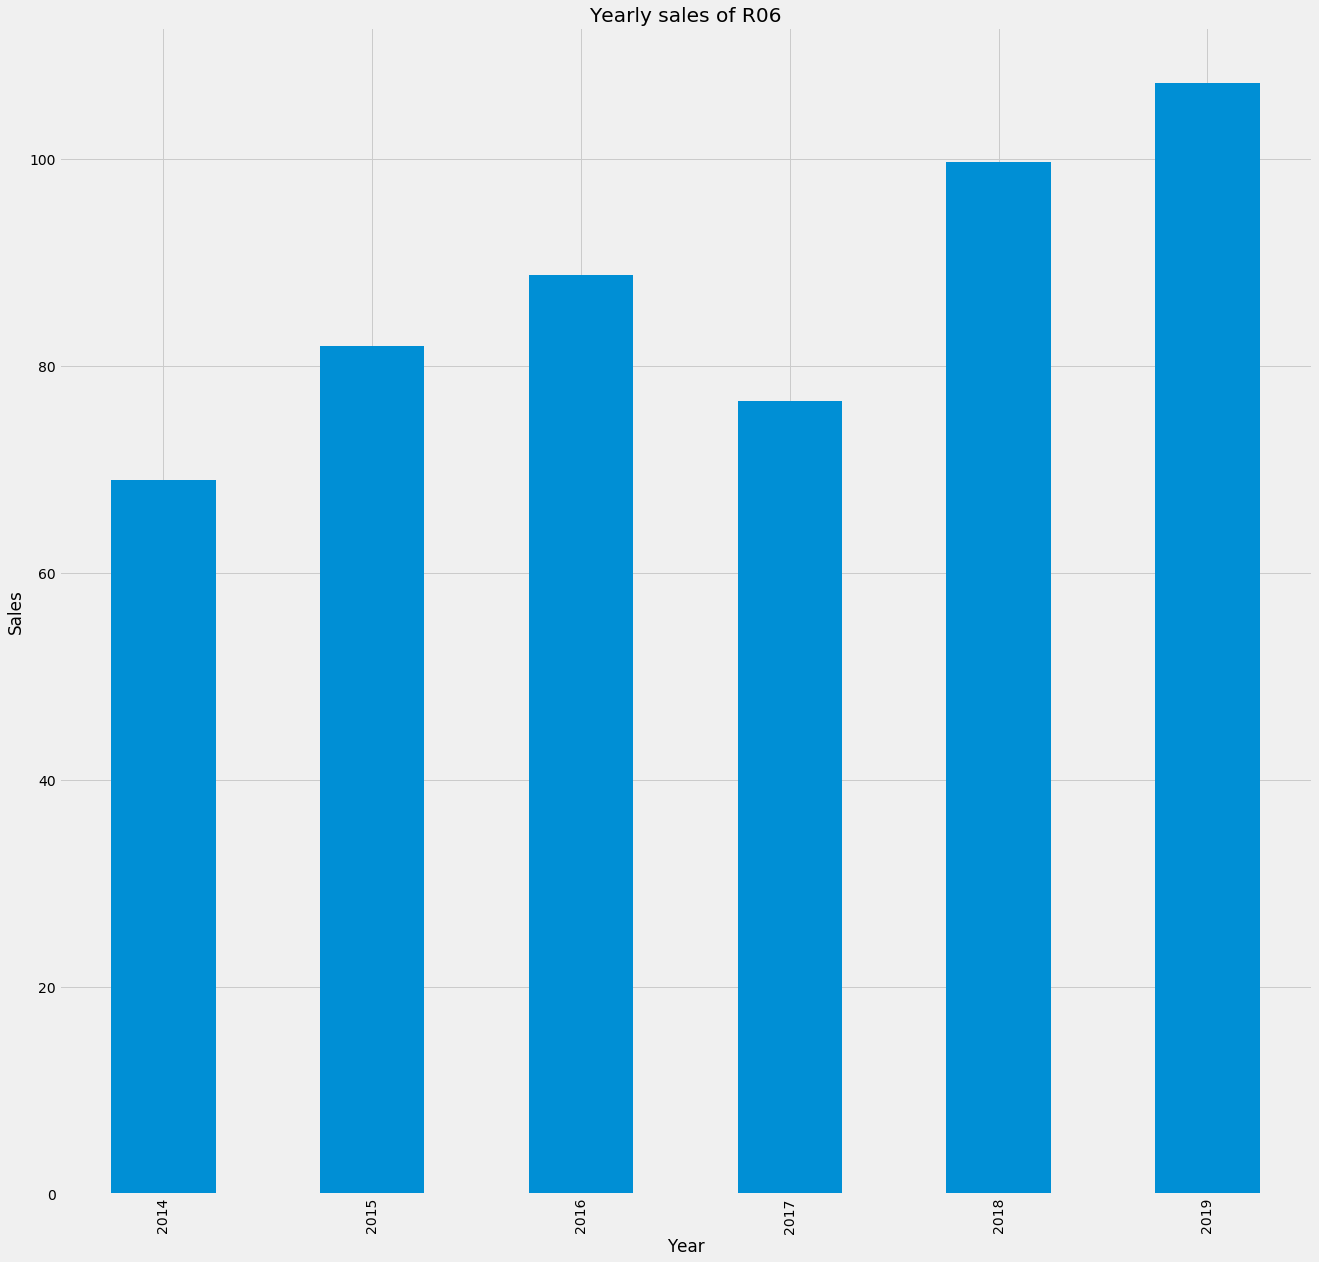

In [170]:
for i in monthlydf.columns[1:9]:
    plot_yearly_sales(i) 

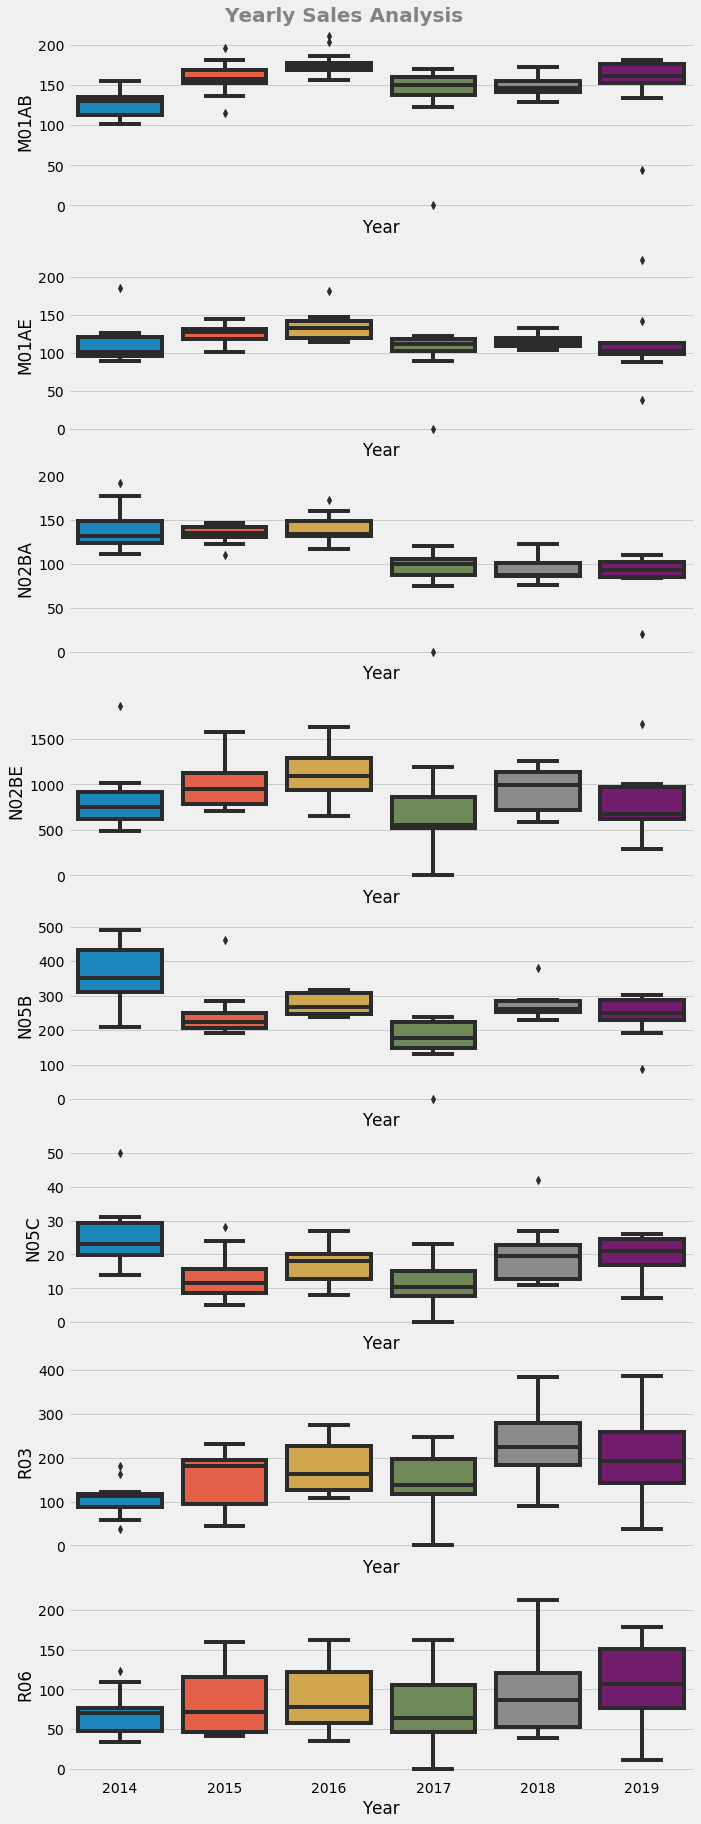

In [169]:
fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
plt.text(x=1, y=2200, s="Yearly Sales Analysis",weight="bold", fontsize=20,color="black", alpha=.45)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.boxplot(data=monthlydf, x='Year', y=name, ax=ax)


### 1. Seasonality analysis
- Analysis below shows 30-day and 365-day rolling mean and 30-day rolling standard deviation of sales data.


In [ ]:
#plot dataframes
#Some seasonability is visible for the categories of R03, R06 and N02BE. 

fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
plt.text(x=1, y=160, s="Monthly Seasonality analysis",weight="bold", fontsize=20,color="black", alpha=.45)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.swarmplot(data=dailydf, x='Month', y=name, ax=ax)
   
#save graph
plt.savefig('graphs/seasonalityAnalysis1.png')
    
    
    

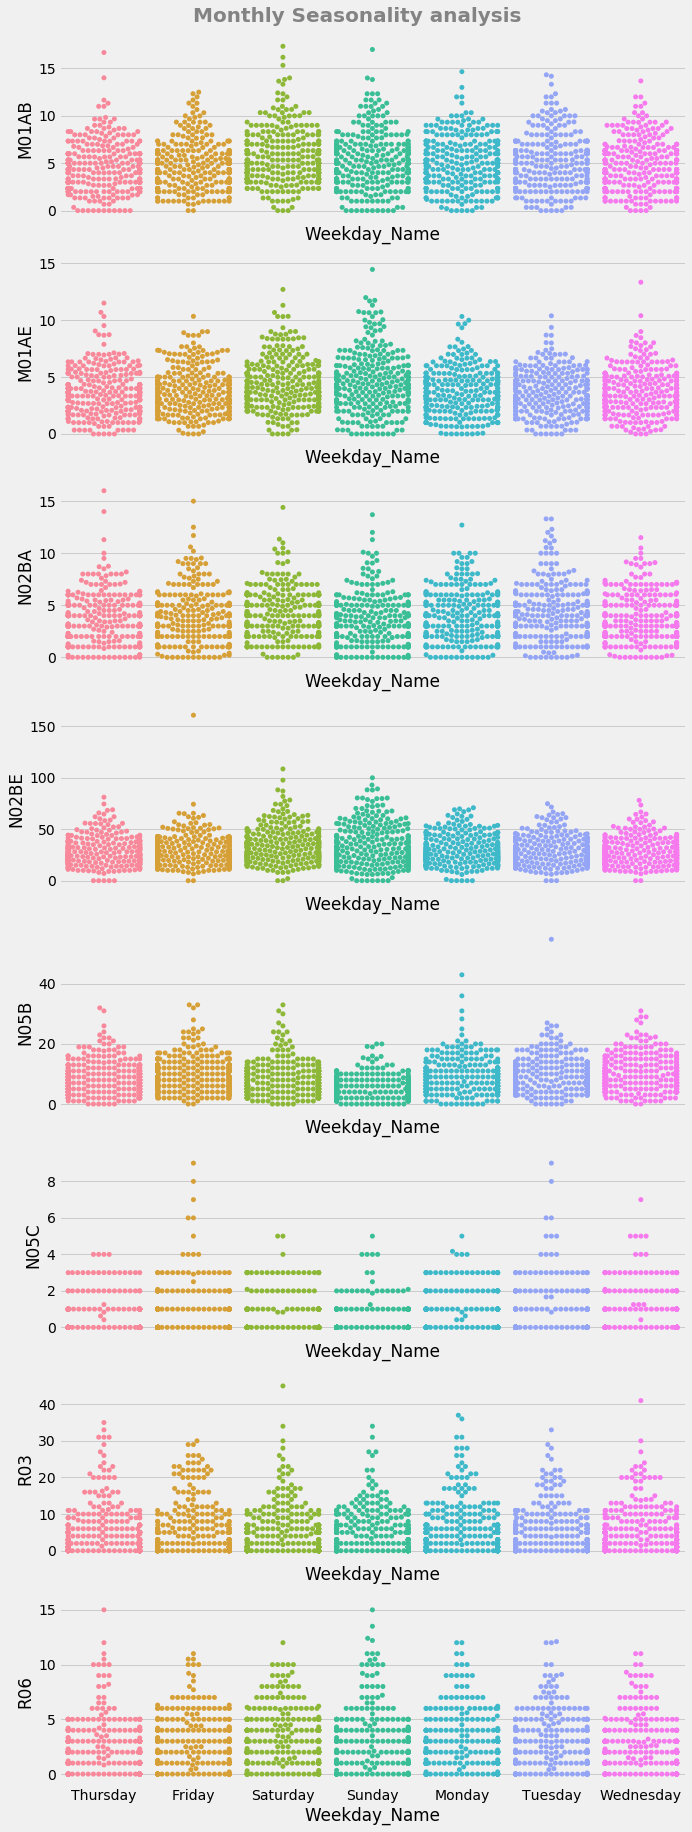

In [111]:
#- R03 and N05C has more outliers that the others, complexity for forecasting
# some weekly seasonability is visible 

fig, axes = plt.subplots(8, 1, figsize=(10, 30), sharex=True)
plt.text(x=1, y=160, s="Monthly Seasonality analysis",weight="bold", fontsize=20,color="black", alpha=.45)
for name, ax in zip(['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06'], axes):
    sns.swarmplot(data=dailydf, x='Weekday_Name', y=name, ax=ax)

    #save graph
plt.savefig('graphs/seasonalityAnalysis2.png')
    

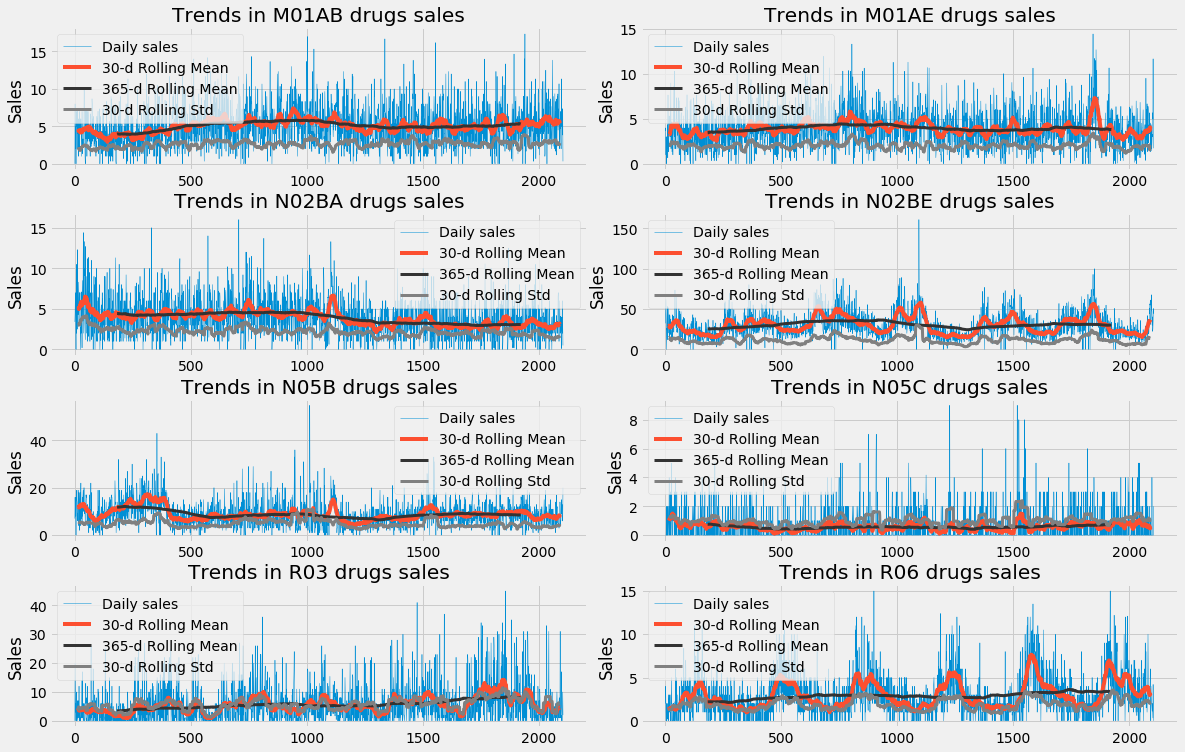

<Figure size 1440x1440 with 0 Axes>

In [112]:
#Analysis below shows 30-day and 365-day rolling mean and 30-day rolling standard deviation of sales data.

cols_plot = ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']
atc_365d = dailydf[cols_plot].rolling(window=365, center=True).mean()
atc_30d = dailydf[cols_plot].rolling(30, center=True).mean()
atc_std = dailydf[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dailydf.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(atc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(atc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(atc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()
#save graph
plt.savefig('graphs/seasonalityTrend.png')

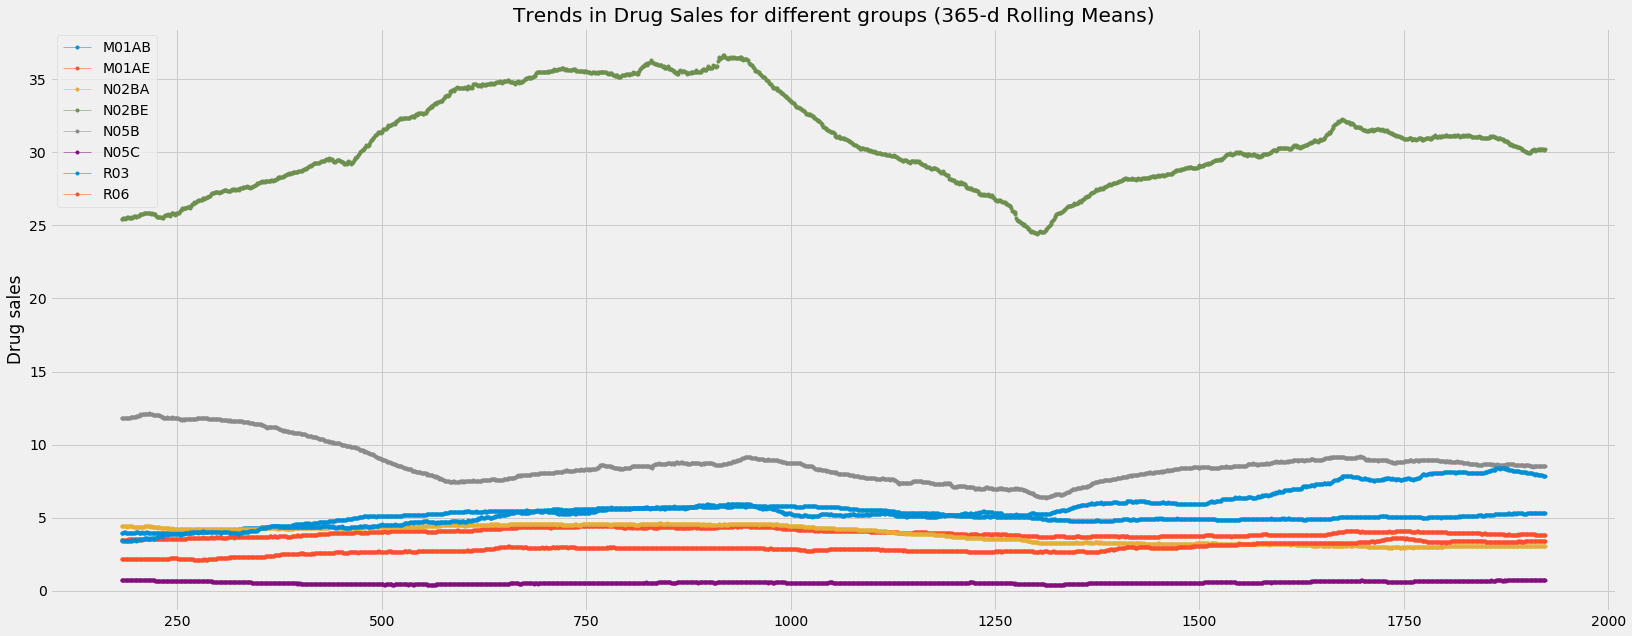

In [113]:
#plot sales trends

fig, ax = plt.subplots(figsize=(25, 10))
for nm in cols_plot:
    ax.plot(atc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

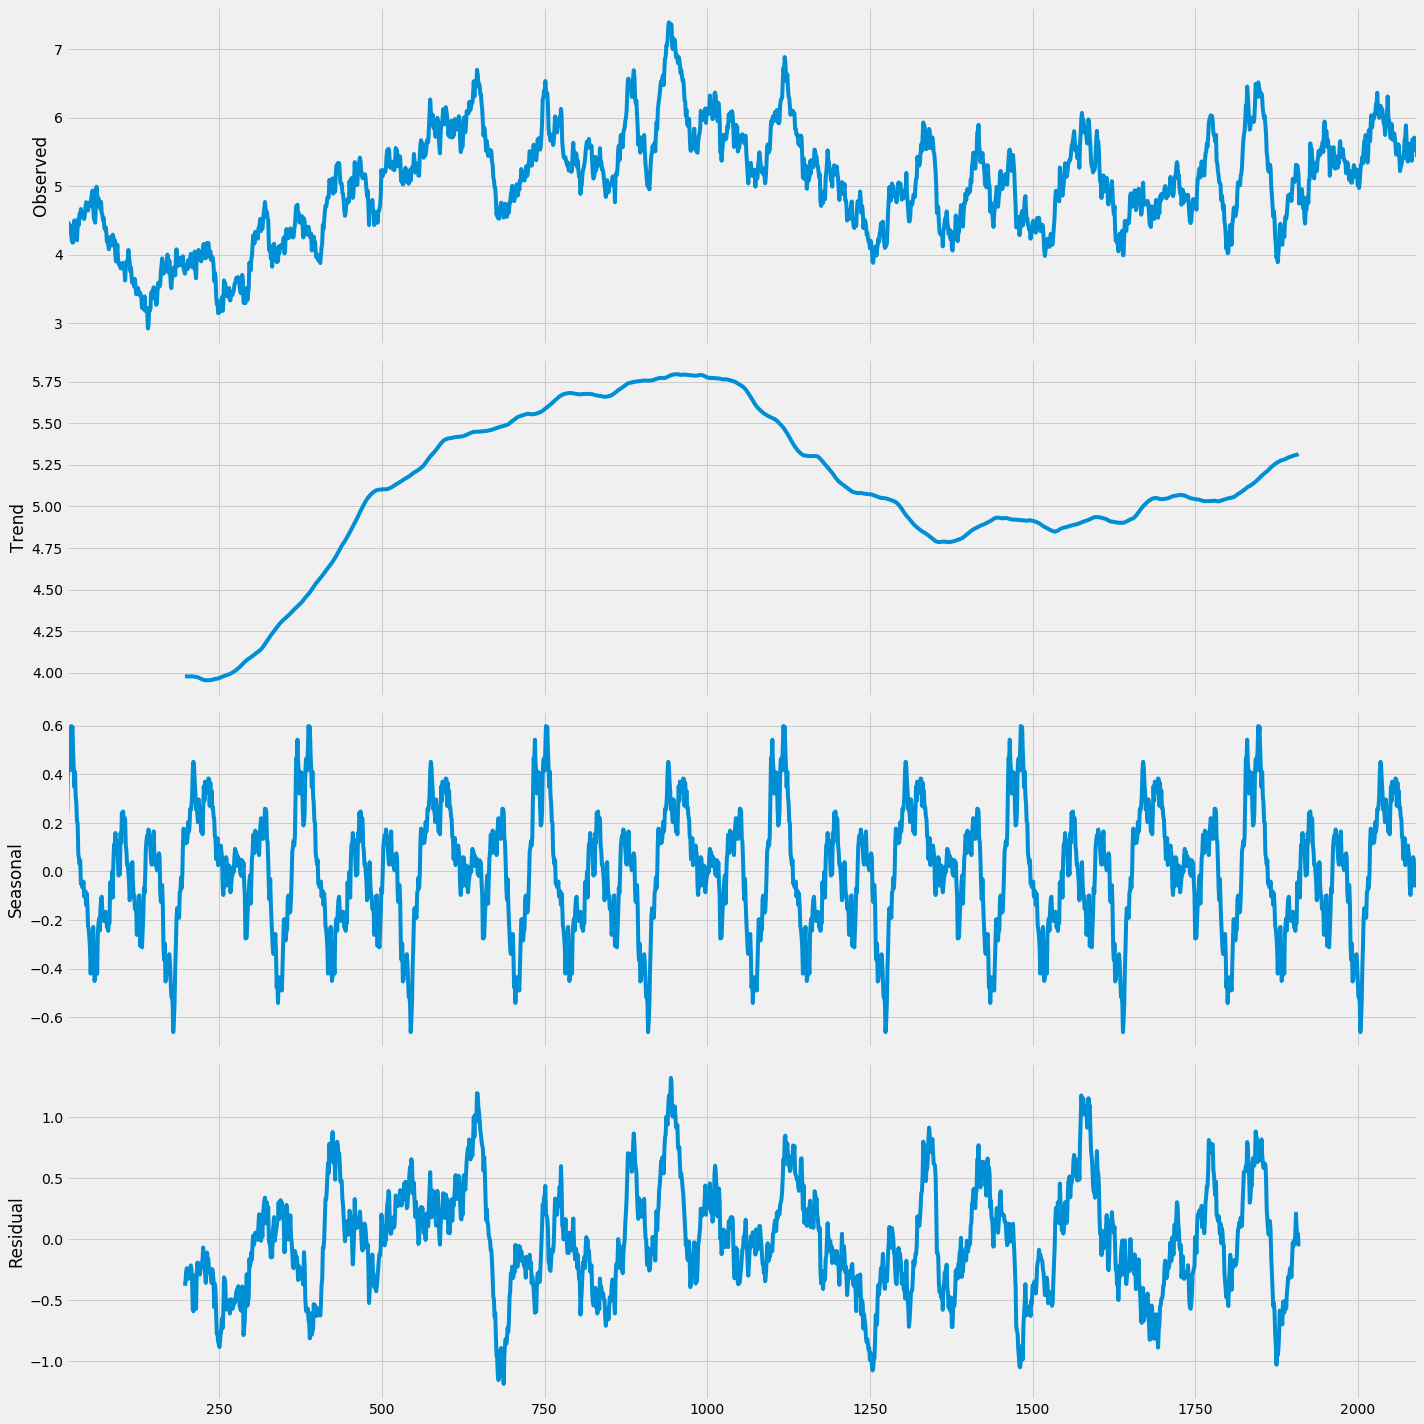

In [114]:
#The volume of this uptake implies the predictability of the time series - higher the residuals, lower the predictability. 
#To some extent, the proportion of the residuals when comparing with trend and seasonality can be also illustrated 
#by the rolling means and standard deviation plots above.

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(dailydf['M01AB'].rolling(30, center=True).mean().dropna(), freq=365, filt=None)
plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

In [ ]:
Stationarity analysis

In [ ]:
Regularity analysis

In [ ]:
Autocorrelation analysis

In [ ]:
Data distribution analysis

In [ ]:
Time series forecasting

In [ ]:
Rolling forecasting with Auto-ARIMA model

In [ ]:
Prophet forecasting

For rolling forecast, ARIMA method (Auto-ARIMA for series with seasonal character) outperforms Prophet and is considered as a best candidate for short-term sales forecasting. 
All methods in all cases (with exception of Prophet N02BE) outperform reference benchmarks - Naive and Seasonal Naive forecasts.